In [ ]:
!pip install tensorflow matplotlib scikit-learn seaborn --quiet

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# ------------------------------
# Load & Preprocess Dataset
# ------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


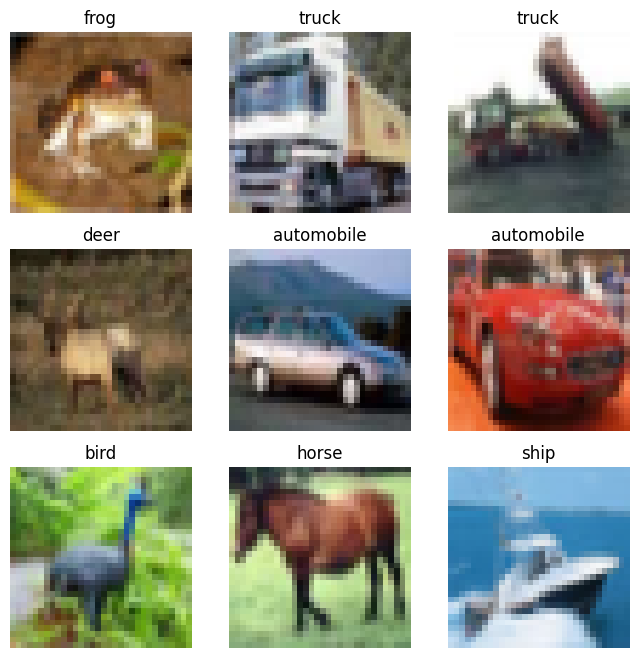

In [ ]:
# Visualize sample images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [ ]:
# ------------------------------
# Build & Train a Basic CNN
# ------------------------------
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))  # reduced epochs for speed

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.3546 - loss: 1.7393 - val_accuracy: 0.5521 - val_loss: 1.2424
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.5897 - loss: 1.1618 - val_accuracy: 0.6339 - val_loss: 1.0408
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - accuracy: 0.6522 - loss: 0.9797 - val_accuracy: 0.6502 - val_loss: 0.9949


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - accuracy: 0.6126 - loss: 1.0999 - val_accuracy: 0.6482 - val_loss: 1.0084
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step - accuracy: 0.6328 - loss: 1.0354 - val_accuracy: 0.6856 - val_loss: 0.9069
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 118ms/step - accuracy: 0.6447 - loss: 1.0054 - val_accuracy: 0.6511 - val_loss: 1.0427
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.77      0.73      1000
  automobile       0.83      0.67      0.74      1000
        bird       0.84      0.30      0.45      1000
         cat       0.56      0.44      0.49      1000
        deer       0.65      0.57      0.61      1000
         dog       0.70      0.48      0.57      1000
        frog       0.71      0.80      0.75      1000
       horse       0.61      0.81      0.70      1000
        ship       0.88      0.70      0.78      1000
   

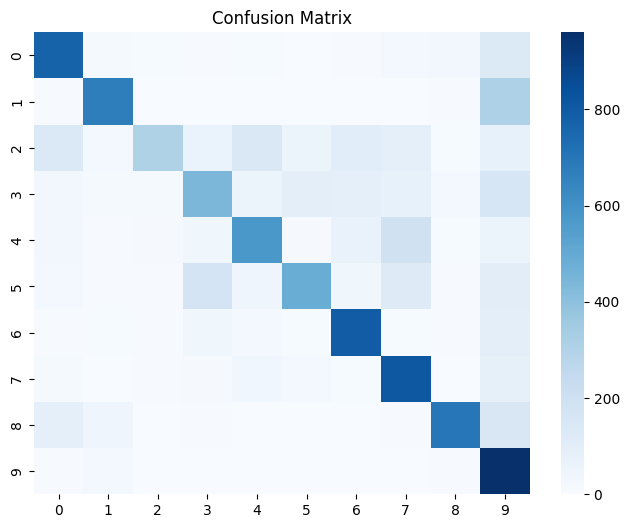

In [ ]:
# ------------------------------
# Data Augmentation & Evaluation
# ------------------------------
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                             height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

aug_model = tf.keras.models.clone_model(cnn_model)
aug_model.set_weights(cnn_model.get_weights())
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
aug_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=3, validation_data=(x_test, y_test))

y_pred = aug_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ------------------------------
# Transfer Learning with MobileNetV2
# ------------------------------
base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3), include_top=False, weights='imagenet')
base_model.trainable = False
transfer_model = models.Sequential([
    tf.keras.layers.Resizing(96,96),  # ✅ fixed
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 409s 258ms/step - accuracy: 0.7105 - loss: 0.8412 - val_accuracy: 0.7909 - val_loss: 0.6005
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 413s 265ms/step - accuracy: 0.8102 - loss: 0.5473 - val_accuracy: 0.7880 - val_loss: 0.6226
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 428s 274ms/step - accuracy: 0.8258 - loss: 0.4915 - val_accuracy: 0.8004 - val_loss: 0.5774
